In [16]:
import numpy as np
import pickle as pk
    
test_data_path = "test_data.pk"
pred_path = "X_pred.pk"

In [17]:
X_pred = pk.load(open(pred_path, "rb"))
X_pred[0].shape

TensorShape([14, 30])

In [18]:
import pickle as pk

test_data = pk.load(open(test_data_path, "rb"))
X_test = test_data["X"][:len(X_pred)]
X_test_oh = test_data["X_oh"][:len(X_pred)]
alphabet_size = test_data["alphabet_size"]

y_test = test_data["y"][:len(X_pred)]
event_mapping = test_data["event_mapping"]

len(X_test), len(y_test), np.unique(y_test, return_counts=True)

(15001, 15001, (array([0, 1]), array([7451, 7550])))

In [19]:
X_test[0].shape, X_pred[0].shape, X_test_oh[0].shape

((14,), TensorShape([14, 30]), (14, 30))

In [20]:
print(event_mapping)

{'1': 0, '4': 1, '3': 2, '13': 3, '25': 4, '19': 5, '5': 6, '21': 7, '22': 8, '26': 9, '23': 10, '27': 11, '17': 12, '20': 13, '28': 14, '9': 15, '24': 16, '14': 17, '7': 18, '11': 19, '<SOS>': 20, '8': 21, '15': 22, '6': 23, '18': 24, '12': 25, '10': 26, '16': 27, '2': 28, '<EOS>': 29}


In [24]:
#top_k = 3
#y_pred_top_k = list()
probabilities = list()
for i, (pred_seq, true_seq) in enumerate(zip(X_pred, X_test_oh)):
    current_probs = list()
    #print(true_seq.shape)
    #print(pred_seq.shape)
    #break
    for p_oh, t_oh in zip(pred_seq, true_seq): 
        #pred_partion = np.argpartition(pred_seq, len(pred_seq) - top_k)[-top_k:]
        true_next_symbol = np.argmax(t_oh)
        true_next_symbol_p = np.max(t_oh)
        pred_next_symbol_p = p_oh[true_next_symbol]        
        current_probs.append(abs(true_next_symbol_p - pred_next_symbol_p))
    probabilities.append(current_probs)

    if i%1000==0:
        print(i)
print(len(probabilities))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
15001


In [25]:
current_labels = y_test[:len(probabilities)]
len(current_labels)

15001

In [26]:
# mean, min
mean_score = list()
min_score = list()
max_score = list()
sum_score = list()
for p in probabilities:
    p = np.array(p)
    mean_score.append(np.mean(p))
    min_score.append(np.min(p))
    max_score.append(np.max(p))
    sum_score.append(np.sum(p))

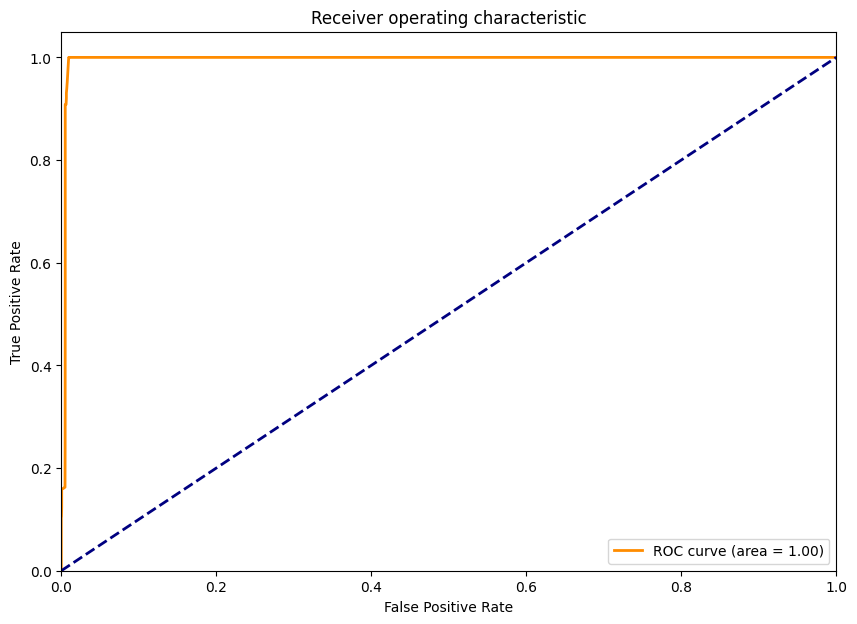

In [27]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

score = max_score

fpr, tpr, thresholds = roc_curve(current_labels, score)
roc_auc = roc_auc_score(current_labels, score)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")

In [28]:
top_k = 6
y_pred_top_k = list()

for pred_seq, true_seq in zip(X_pred, X_test_oh):
    is_anomaly = False
    for j, (p_oh, t_oh) in enumerate(zip(pred_seq, true_seq)):
        if j==len(p_oh)-1:
            break
        pred_partition = np.argpartition(p_oh, len(p_oh) - top_k)[-top_k:]
        
        true_next_symbol = np.argmax(t_oh)
        if not true_next_symbol in set(list(pred_partition)):
            is_anomaly = True
    y_pred_top_k.append(1 if is_anomaly else 0)
print(y_pred_top_k[:5]), len(y_pred_top_k), len(X_pred), np.unique(y_pred_top_k, return_counts=True)

[0, 0, 1, 1, 1]


(None, 15001, 15001, (array([0, 1]), array([6968, 8033])))

In [29]:
y_test[:5]

(0, 0, 1, 1, 1)

In [30]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test[:len(y_pred_top_k)], y_pred_top_k)

0.9504699686687554